In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(magrittr)
library(ggplot2)
library(ggiraph)
library(dplyr)

OUT_DIR <- "/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcga/output/"
OUT_DIR2 <- "/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcga/output_ARI/"


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
rxn2ensembls.nls <- readRDS(paste(OUT_DIR, "rxn2ensembls_nls.Rds", sep = ""))
rxn_knn_misclass_rate.nls <- readRDS(paste(OUT_DIR, "toi_rxn_knn_misclass_rate_nls.Rds", sep = ""))
rxn_knn_ari.nls <- readRDS(paste(OUT_DIR, "toi_rxn_knn_ari_nls.Rds", sep = ""))
rxn_knn_ecount.nls <- readRDS(paste(OUT_DIR, "toi_rxn_knn_ecount_nls.Rds", sep = ""))
tcga_tissue_detail.vec.train <- readRDS(paste(OUT_DIR,"tcga_tissue_detial_vec_train.Rds",sep=""))
vst.count.mtx.train <- readRDS(paste(OUT_DIR,"vst_count_mtx_train.Rds",sep=""))
rxn_pca.nls <- readRDS(paste(OUT_DIR,"rxn_pca_nls.Rds",sep=""))

In [4]:
%%R
head(rxn2ensembls.nls)

$`R-MMU-450466`
 [1] "ENSMUSG00000000568" "ENSMUSG00000002102" "ENSMUSG00000018286"
 [4] "ENSMUSG00000021024" "ENSMUSG00000021178" "ENSMUSG00000021737"
 [7] "ENSMUSG00000021832" "ENSMUSG00000029440" "ENSMUSG00000030591"
[10] "ENSMUSG00000030603" "ENSMUSG00000030751" "ENSMUSG00000032869"
[13] "ENSMUSG00000040850" "ENSMUSG00000068749" "ENSMUSG00000069744"
[16] "ENSMUSG00000078652" "ENSMUSG00000079197"

$`R-MMU-450551`
[1] "ENSMUSG00000000568" "ENSMUSG00000022283" "ENSMUSG00000090877"
[4] "ENSMUSG00000091971"

$`R-MMU-450580`
[1] "ENSMUSG00000000568" "ENSMUSG00000022283" "ENSMUSG00000090877"
[4] "ENSMUSG00000091971"

$`R-MMU-72103`
 [1] "ENSMUSG00000000568" "ENSMUSG00000002658" "ENSMUSG00000006498"
 [4] "ENSMUSG00000007850" "ENSMUSG00000018379" "ENSMUSG00000019738"
 [7] "ENSMUSG00000021018" "ENSMUSG00000021546" "ENSMUSG00000024097"
[10] "ENSMUSG00000028330" "ENSMUSG00000029250" "ENSMUSG00000029538"
[13] "ENSMUSG00000030795" "ENSMUSG00000031060" "ENSMUSG00000031134"
[16] "ENSMUSG0000003178

In [5]:
%%R
head(rxn_knn_misclass_rate.nls)

$`R-MMU-450466`
$`R-MMU-450466`$Brain
[1] 0.0546183

$`R-MMU-450466`$Liver
[1] 0.04357759

$`R-MMU-450466`$Intestine
[1] 0.01939406

$`R-MMU-450466`$Eye
[1] 0.01385117

$`R-MMU-450466`$Heart
[1] 0.009671371

$`R-MMU-450466`$MOE
[1] 0.0006756757

$`R-MMU-450466`$Muscle
[1] 0.008990449

$`R-MMU-450466`$Lung
[1] 0.01245815

$`R-MMU-450466`$Kidney
[1] 0.01723447

$`R-MMU-450466`$Pancreas
[1] 0.02074988

$`R-MMU-450466`$Testes
[1] 0.009723145

$`R-MMU-450466`$Adipose
[1] 0.02142549

$`R-MMU-450466`$Skin
[1] 0.01382833


$`R-MMU-450551`
$`R-MMU-450551`$Brain
[1] 0.1079109

$`R-MMU-450551`$Liver
[1] 0.1459799

$`R-MMU-450551`$Intestine
[1] 0.1038193

$`R-MMU-450551`$Eye
[1] 0.03318

$`R-MMU-450551`$Heart
[1] 0.03452584

$`R-MMU-450551`$MOE
[1] 0.01385642

$`R-MMU-450551`$Muscle
[1] 0.05678707

$`R-MMU-450551`$Lung
[1] 0.06368059

$`R-MMU-450551`$Kidney
[1] 0.06503071

$`R-MMU-450551`$Pancreas
[1] 0.0533164

$`R-MMU-450551`$Testes
[1] 0.0242078

$`R-MMU-450551`$Adipose
[1] 0.06225745

$`R-MMU-

In [6]:
%%R
head(rxn_knn_ari.nls)

$`R-MMU-450466`
[1] 0.7778175

$`R-MMU-450551`
[1] 0.4403143

$`R-MMU-450580`
[1] 0.4403143

$`R-MMU-72103`
[1] 0.7695079

$`R-MMU-9770119`
[1] 0.7426277

$`R-MMU-9770141`
[1] 0.7494174



In [7]:
%%R
head(rxn_knn_ecount.nls)

$`R-MMU-450466`
[1] 17

$`R-MMU-450551`
[1] 4

$`R-MMU-450580`
[1] 4

$`R-MMU-72103`
[1] 23

$`R-MMU-9770119`
[1] 33

$`R-MMU-9770141`
[1] 61



In [8]:
%%R
print(length(unique(tcga_tissue_detail.vec.train)))
print(tcga_tissue_detail.vec.train)

[1] 13
   [1] "Brain"     "Liver"     "Brain"     "Intestine" "Liver"     "Liver"    
   [7] "Liver"     "Liver"     "Eye"       "Heart"     "Brain"     "Intestine"
  [13] "Brain"     "Brain"     "MOE"       "Liver"     "Muscle"    "Liver"    
  [19] "Muscle"    "Lung"      "Heart"     "Liver"     "Liver"     "Lung"     
  [25] "Brain"     "Liver"     "Liver"     "Liver"     "Liver"     "Kidney"   
  [31] "Pancreas"  "Pancreas"  "Liver"     "Brain"     "Brain"     "Brain"    
  [37] "Muscle"    "Pancreas"  "Lung"      "Brain"     "Liver"     "Intestine"
  [43] "Liver"     "Brain"     "Muscle"    "Brain"     "Liver"     "Kidney"   
  [49] "Testes"    "Pancreas"  "Lung"      "Adipose"   "Eye"       "Liver"    
  [55] "Brain"     "Liver"     "Brain"     "Liver"     "Brain"     "Lung"     
  [61] "Brain"     "Adipose"   "Liver"     "Kidney"    "Liver"     "Intestine"
  [67] "Liver"     "Adipose"   "Testes"    "Brain"     "Liver"     "Adipose"  
  [73] "Liver"     "Adipose"   "Liver"     "B

 [619] "Brain"     "Liver"     "Brain"     "Pancreas"  "Kidney"    "Kidney"   
 [625] "Eye"       "Liver"     "Liver"     "Liver"     "Kidney"    "Lung"     
 [631] "Brain"     "Liver"     "Brain"     "Kidney"    "Adipose"   "Lung"     
 [637] "Muscle"    "Brain"     "Liver"     "Brain"     "Brain"     "Skin"     
 [643] "Kidney"    "Testes"    "Brain"     "Lung"      "Brain"     "Brain"    
 [649] "Intestine" "Liver"     "Brain"     "Liver"     "Brain"     "Liver"    
 [655] "Pancreas"  "Intestine" "Brain"     "Pancreas"  "Liver"     "Muscle"   
 [661] "Liver"     "Kidney"    "Kidney"    "Kidney"    "Muscle"    "Brain"    
 [667] "Kidney"    "Lung"      "Adipose"   "Intestine" "Liver"     "Testes"   
 [673] "Liver"     "MOE"       "Adipose"   "Skin"      "Intestine" "Brain"    
 [679] "Liver"     "Liver"     "Liver"     "Liver"     "Intestine" "Brain"    
 [685] "Brain"     "Brain"     "Muscle"    "Pancreas"  "Brain"     "Heart"    
 [691] "Liver"     "Liver"     "Muscle"    "Intestin

[1237] "Pancreas"  "Brain"     "Kidney"    "Pancreas"  "Adipose"   "Liver"    
[1243] "Brain"     "Lung"      "Testes"    "Adipose"   "Liver"     "Muscle"   
[1249] "Liver"     "Liver"     "Brain"     "Brain"     "Liver"     "Kidney"   
[1255] "Intestine" "Testes"    "Muscle"    "Brain"     "Liver"     "Brain"    
[1261] "Brain"     "Adipose"   "Lung"      "Liver"     "Skin"      "Brain"    
[1267] "Liver"     "Pancreas"  "Lung"      "Liver"     "Eye"       "Adipose"  
[1273] "Intestine" "Liver"     "Intestine" "Pancreas"  "Pancreas"  "Intestine"
[1279] "Brain"     "Intestine" "Intestine" "Testes"    "Liver"     "Kidney"   
[1285] "Liver"     "Adipose"   "Liver"     "Liver"     "Liver"     "Intestine"
[1291] "Brain"     "Brain"     "Brain"     "Liver"     "Adipose"   "Brain"    
[1297] "Muscle"    "Brain"     "Liver"     "Kidney"    "Liver"     "Liver"    
[1303] "Liver"     "Liver"     "Liver"     "Adipose"   "Eye"       "Brain"    
[1309] "Intestine" "Brain"     "Liver"     "Skin"   

In [9]:
%%R
head(vst.count.mtx.train)

                          V1        V2        V3        V4        V5        V6
ENSMUSG00000000568 12.089741 12.007039  7.738357 10.526209 11.346734 10.480102
ENSMUSG00000000579  1.973521  6.214372  8.226375  5.726502 -0.575148  1.550641
ENSMUSG00000000581 10.806813  7.100502 10.201818  8.872531  9.611739  8.762204
ENSMUSG00000000594 12.120223  7.785198 15.620373  8.942452 14.569644 13.417349
ENSMUSG00000000605  8.795801 12.670783  8.544524 11.087228 12.874628 10.968780
ENSMUSG00000000617 -4.316866 -2.982723 -4.303475 -4.281236 -4.310218 -4.335979
                          V7        V8        V9       V10       V11       V12
ENSMUSG00000000568 11.734607 10.909107 13.787988 11.612339 12.715014 10.690964
ENSMUSG00000000579  2.455653 -1.730175  3.351378  5.410391  1.561563  6.333806
ENSMUSG00000000581 12.282308 11.317591  9.625275  9.060876  8.942830  8.216700
ENSMUSG00000000594 14.418388 13.575597  8.017760  8.878524 10.847136  9.023202
ENSMUSG00000000605 13.409717 12.348519 13.802648 12.

ENSMUSG00000000579  2.304605  2.294648  4.821782  4.177198  2.393198  1.291046
ENSMUSG00000000581  9.151364  9.808290  9.250260  8.832615 10.909118  7.632331
ENSMUSG00000000594  9.374472  9.268952 14.252725 15.049672 14.442134 11.770379
ENSMUSG00000000605 13.368038 12.114433 13.412010 11.362900 12.986823 10.815243
ENSMUSG00000000617 -4.351619 10.141686 -4.239626 -4.386183 -1.302183 -3.081693
                         V92       V93        V94       V95      V96       V97
ENSMUSG00000000568 11.929196 12.607894 10.2285587  9.797181 6.326139 10.556393
ENSMUSG00000000579  4.457386  3.558774 -0.8921282  2.892524 6.326139  0.328764
ENSMUSG00000000581  9.752606  8.423985 10.3947227  8.328029 6.326139 11.049753
ENSMUSG00000000594  9.694323 10.444992 13.4310571  9.137773 6.326139 13.508708
ENSMUSG00000000605 13.588438 13.578024 11.9290763 10.821979 6.326139 12.292844
ENSMUSG00000000617 11.810670 -3.497781 -1.7687644 -3.230543 6.326139 -4.252172
                          V98        V99      V100  

ENSMUSG00000000581  8.290826 10.166201 11.0737865  9.024580 14.928532 26.612275
ENSMUSG00000000594  9.166742 11.313283 14.6482234 14.914163  8.710228 25.500211
ENSMUSG00000000605 10.496139 12.140428 11.0658374 11.193497 10.800240  4.717275
ENSMUSG00000000617 -3.629895 -4.171197 -3.6111964 -2.969461  3.534435  4.717275
                        V177      V178      V179       V180     V181      V182
ENSMUSG00000000568 11.783484 10.935696 13.360609 10.4900915 6.394972 22.922857
ENSMUSG00000000579  2.337218  8.133853  2.553016 -0.5714234 6.394972  5.647708
ENSMUSG00000000581 10.704192  7.627647  9.294656 15.5634425 6.394972  5.647708
ENSMUSG00000000594  9.037094 11.006982  9.471286 18.1961209 6.394972 18.966373
ENSMUSG00000000605 12.541500  9.629570 13.263021 10.9960542 6.394972 21.958770
ENSMUSG00000000617 -4.319235 -4.063497 -4.353149 -4.1577933 6.394972  5.647708
                        V183      V184      V185     V186      V187      V188
ENSMUSG00000000568  9.917356 12.023955 10.840176 

ENSMUSG00000000581 10.0152438  8.959990  8.743254  7.571647  7.5542500
ENSMUSG00000000594 14.7513386 11.435503 11.612804 11.156365  9.3813422
ENSMUSG00000000605 12.6063319 11.708342 11.523796  9.697924 10.7840884
ENSMUSG00000000617 -4.3186329 -3.117026 -2.419806 -4.318185  0.2573472
                        V263      V264      V265      V266      V267      V268
ENSMUSG00000000568  7.926205 14.771533 13.394857 13.028263  7.066071  9.544371
ENSMUSG00000000579  0.591807  1.937771  2.250578  2.269170  7.554068  6.294375
ENSMUSG00000000581 10.271272 16.263996  6.762598  7.396497 14.066771  8.380464
ENSMUSG00000000594 10.649295 13.572029 10.226854 11.065372 13.208964  8.198388
ENSMUSG00000000605 16.299510 17.421758 13.394368 12.481341  7.542005 10.718431
ENSMUSG00000000617 -4.266855 -4.320327 -2.536498 -4.386138 -2.829295 -2.625774
                        V269      V270       V271      V272      V273      V274
ENSMUSG00000000568 13.725548  3.511272  0.5362125  9.533940 12.735475 11.558457
ENS

ENSMUSG00000000568 11.580679  7.694887 10.295146 10.153949 13.115547 11.304923
ENSMUSG00000000579  5.431295  5.774863  1.033368  5.085204  9.383195  1.634249
ENSMUSG00000000581 10.276338 11.454163 10.093761  6.729565 14.846054  7.987553
ENSMUSG00000000594 15.019591  9.452201 13.951831 10.322590  7.870007  9.586573
ENSMUSG00000000605 11.552613 12.034152 12.288258 10.513089  9.423812 11.156030
ENSMUSG00000000617 -4.359694 -4.370318 -4.280539 -4.256355  1.277278 -2.502157
                      V353      V354      V355      V356      V357      V358
ENSMUSG00000000568 6.20276 -4.253168 11.173976 14.063745 12.749702 11.774791
ENSMUSG00000000579 6.20276  4.576153  4.128397  2.302248  5.165021  3.453507
ENSMUSG00000000581 6.20276 10.906329 11.878087  9.723077 10.728910 11.656759
ENSMUSG00000000594 6.20276 10.839117 14.954619 11.551133 10.556267  9.863832
ENSMUSG00000000605 6.20276 -4.253168 12.118406 13.635421 10.348938 12.836601
ENSMUSG00000000617 6.20276 -4.253168 -4.279134 -4.340776 -4.3829

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  5.951160  4.231644
ENSMUSG00000000581  9.280070  6.595700  9.552498  9.270400  9.011922  8.431694
ENSMUSG00000000594  8.938533 15.144697 11.108891  8.679186 11.482578 11.860654
ENSMUSG00000000605 12.444568 10.368640 14.148705 13.198954 10.980350 11.230891
ENSMUSG00000000617 -4.364770 -4.394675 -2.007562 -4.349546 -2.113862 -4.345023
                        V810      V811      V812       V813      V814      V815
ENSMUSG00000000568  9.487640 13.096702 13.274699 12.1311801 27.496432 12.049618
ENSMUSG00000000579  5.931384  3.941252  6.208978 -0.3583027  4.460281  3.634460
ENSMUSG00000000581  7.796457 10.541507  3.368959 10.3773468  4.460281 11.377316
ENSMUSG00000000594 10.790910 11.665842  4.779813 16.2910538  4.460281 13.740177
ENSMUSG00000000605 11.248522 14.859227 -4.148210 13.9191240  4.460281 12.384052
ENSMUSG00000000617 -3.249445 -4.005595 -1.875895 -4.2089655  4.460281 -3.695678
                        V816      V817      V818      V819       V820      V821
ENSMUSG00000000568 24.2

ENSMUSG00000000594 13.191463 11.365740  7.770990 14.679921 14.7601389 14.179839
ENSMUSG00000000605 11.600727 13.592624 12.457737 12.702559 12.1657009 13.168030
ENSMUSG00000000617 -4.237280 -4.389849 -4.345886 -2.850743 -4.3155492 -4.283400
                        V895      V896      V897      V898      V899       V900
ENSMUSG00000000568  9.749907  7.681155 11.468974 10.903168 10.810115 14.5354989
ENSMUSG00000000579  1.908979  5.747418  4.293045  2.408447  3.815760  0.4738216
ENSMUSG00000000581  6.598619 11.442510  7.644207  9.957162  9.204836  8.5131407
ENSMUSG00000000594 11.116908  9.438400 10.837425 12.022283 11.361942 18.4103148
ENSMUSG00000000605 10.176739 12.016804 10.757598 12.368745  6.571023 13.0760432
ENSMUSG00000000617 -0.687469 -4.370486 -1.735405 -1.398804 -2.873137 -4.1962834
                        V901      V902      V903      V904      V905      V906
ENSMUSG00000000568 11.899760 12.043145 13.860934 11.748323 11.571765 13.353307
ENSMUSG00000000579  7.649347 -2.206773  4.

ENSMUSG00000000581 11.842446 10.5119103  8.402836  8.836476  9.520315  8.866755
ENSMUSG00000000594 14.304391 13.1739545 12.662451 10.435771 14.846406  8.782424
ENSMUSG00000000605 10.765991 12.3296830 11.830129 10.579633 12.422830 11.434899
ENSMUSG00000000617 -3.518075 -4.3378895 -4.204528 -4.360442 -2.774048 -4.281615
                        V983      V984         V985      V986      V987
ENSMUSG00000000568  9.689188 12.472703 11.137165100 10.975759 11.442660
ENSMUSG00000000579  6.131378  2.512894  0.004664905  5.150397  6.734952
ENSMUSG00000000581  8.922876 10.904941 11.348072080  9.813557  9.476087
ENSMUSG00000000594  9.148984 12.326833 14.909586545 14.957088  9.389484
ENSMUSG00000000605 10.108075 12.298773 12.614240450 12.295517 11.402599
ENSMUSG00000000617 -1.699138 -4.292700 -4.087844509 -4.343281 -3.682370
                        V988     V989      V990      V991      V992      V993
ENSMUSG00000000568  7.629213 10.43958 11.819162  9.418739 10.866128  9.048182
ENSMUSG00000000579  

ENSMUSG00000000605 12.861535 11.915516 14.248812 10.110554 12.557217 11.046002
ENSMUSG00000000617 -4.222751 -1.715542  8.167851 -4.269090 -4.298578 -4.253919
                       V1067     V1068      V1069     V1070     V1071     V1072
ENSMUSG00000000568 10.190259 11.494629 13.0248222  9.555986 11.269846  9.676309
ENSMUSG00000000579  4.184103  2.543299  0.5679166  7.288070  7.589512  5.217207
ENSMUSG00000000581 10.656026  9.400437 12.6962054  9.245401  8.923577  6.986655
ENSMUSG00000000594 14.780231  7.916346 14.1358795  8.173255  8.226978 10.027935
ENSMUSG00000000605 12.402909 11.962175 12.4453904 12.088650 10.451359 10.660733
ENSMUSG00000000617 -4.282538 -4.265978 -4.1212749 -4.384066 -4.206042 -1.270044
                       V1073    V1074     V1075     V1076     V1077     V1078
ENSMUSG00000000568 14.393778 4.480644  9.218297 11.352797 10.862976 10.160921
ENSMUSG00000000579  4.832121 4.480644  4.995515  4.682081  2.687741  7.574946
ENSMUSG00000000581  4.832121 4.480644  8.905189 

ENSMUSG00000000605 12.818608 11.911543 13.893388 18.89668 11.284439 12.674399
ENSMUSG00000000617 -4.228429 -4.354198 -3.091382  5.57736 -1.522812 -4.225189
                       V1154     V1155     V1156     V1157     V1158     V1159
ENSMUSG00000000568 10.724471 10.224255 10.051704 11.815247 12.160143  9.133185
ENSMUSG00000000579  5.604492  5.566821  5.099154  1.861404  5.741058  3.652005
ENSMUSG00000000581 10.243376  8.795981  8.601771 10.417045  7.495145  9.560378
ENSMUSG00000000594  7.598004  8.779262 10.372048  8.779989  8.794047 14.722848
ENSMUSG00000000605 13.227036 11.243989 14.354318 13.511443 11.980364 13.321982
ENSMUSG00000000617  9.674660 -4.283638 -4.359670 -4.235957 11.809334 -4.270198
                       V1160     V1161     V1162     V1163     V1164     V1165
ENSMUSG00000000568 16.015745 11.797588 10.745669 10.155637 11.490702 11.069724
ENSMUSG00000000579  3.227657  5.930179  4.490919  4.033881  9.020489  3.687543
ENSMUSG00000000581  8.313965  8.599879  8.571944  9.32

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
%%R
head(rxn_pca.nls)

$`R-MMU-450466`
           V1            V2            V3            V4            V5 
 -0.163662216  -2.347765486   1.556805519  -0.619606882   2.401658061 
           V6            V7            V8            V9           V10 
 -0.868579180   3.316488132   1.317908436  -1.602001023   1.297525565 
          V11           V12           V13           V14           V15 
 -1.973353527  -1.170792928   0.387770964  -8.152348746  -0.372725653 
          V16           V17           V18           V19           V20 
  1.482468007   0.274298651   1.034790335   1.467630475  -1.486806559 
          V21           V22           V23           V24           V25 
  4.723405994   0.963992437   2.089951025  -1.339732683  -1.096060232 
          V26           V27           V28           V29           V30 
  1.767159461   1.356988892   2.021460000   2.544444556   1.157884823 
          V31           V32           V33           V34           V35 
 -0.969678336  -1.171730474   1.756384558  -1.136432315  -1.0

 -0.519374301   0.656037439   1.332874345   1.489279271  -1.184084352 
         V291          V292          V293          V294          V295 
 -1.360242499  -1.641656916  -1.138244001  -1.103317219  -1.418063031 
         V296          V297          V298          V299          V300 
  4.322541625   0.938803766   1.713610306   0.737414135  -1.093566666 
         V301          V302          V303          V304          V305 
  1.180223512   1.233878338   0.313216998   2.937005214  -2.131281699 
         V306          V307          V308          V309          V310 
 -0.725093398   1.083377151  -1.351349731  -5.020247346  -3.006577257 
         V311          V312          V313          V314          V315 
 -1.015309214   1.841963832   0.025665283   0.193528421   1.033176330 
         V316          V317          V318          V319          V320 
  0.033300209  -0.770075713  -1.035909768  -0.520701555   2.672364582 
         V321          V322          V323          V324          V325 
 -0.94

         V576          V577          V578          V579          V580 
 -1.602445366  -0.162287970  -1.486114888   1.573434194  -1.377698021 
         V581          V582          V583          V584          V585 
 -1.654367852   2.163020639   2.358982143  -4.795203872  -0.407618274 
         V586          V587          V588          V589          V590 
 -0.222788171  -1.892794008  -1.037398167   5.847730791   0.497245475 
         V591          V592          V593          V594          V595 
 -1.368032823  -0.567258814   2.716572200  -6.509277953  -1.747992055 
         V596          V597          V598          V599          V600 
 -0.764126090  -1.819422907   1.339894810  -0.844358209  -2.424568168 
         V601          V602          V603          V604          V605 
 -0.839096962  -0.872103622  -1.075963668  -0.541691905  -0.650290454 
         V606          V607          V608          V609          V610 
  4.503808729   2.838211995   0.145260115  -0.599687508  -0.659339672 
      

  2.859387848  -0.734020900  -2.113667633  -1.170414082  -0.757045786 
         V866          V867          V868          V869          V870 
  0.657660982   2.217226932  -0.669734944   1.753792177   0.017460636 
         V871          V872          V873          V874          V875 
  2.515772899   1.065997402   0.735111398   1.490810438  -3.192962517 
         V876          V877          V878          V879          V880 
  0.479448035  -0.934235224  -1.204874896  -0.338300358   1.774084379 
         V881          V882          V883          V884          V885 
 -0.284764930  -0.525992834  -1.415082414   2.185457408   2.378339059 
         V886          V887          V888          V889          V890 
 -2.315286860  -0.780280530   2.487252800   0.561382501  -2.115720485 
         V891          V892          V893          V894          V895 
 -0.419831003   1.305220530   0.907116499   3.314911444  -3.639141288 
         V896          V897          V898          V899          V900 
  1.31

        V1151         V1152         V1153         V1154         V1155 
 -2.799731399  -0.747962615   0.776417547  -0.385841251  -0.696578901 
        V1156         V1157         V1158         V1159         V1160 
 -1.228875579   2.217577557  -2.243630763   1.907854861   1.245729194 
        V1161         V1162         V1163         V1164         V1165 
 -1.555691273  -1.402048478   1.875162732  -0.349259023   1.127650861 
        V1166         V1167         V1168         V1169         V1170 
 -2.876640213   0.376083020  -1.809663214   0.501964006  -0.508019889 
        V1171         V1172         V1173         V1174         V1175 
  0.375724205  -1.105236897  -1.067823657  -1.253485846  -1.641162768 
        V1176         V1177         V1178         V1179         V1180 
 -1.787881864  -1.239590799   0.493135108   3.286045804   1.010754346 
        V1181         V1182         V1183         V1184         V1185 
 -2.188580909   1.245567014  -1.738865774   3.373978305   1.748825661 
      

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0.5625258931 -0.1106772262 -0.1404453808  0.8383035251 
        V1361         V1362         V1363         V1364         V1365 
 0.3484421433 -1.0132843655  0.3165994917  0.8857294595  0.0183082067 
        V1366         V1367         V1368         V1369         V1370 
 2.6184158052 -1.1879663739 -0.9013522412  1.1737825175 -0.5412260109 
        V1371         V1372         V1373         V1374         V1375 
-0.8817640568  2.3292280240  0.3374494401  0.0570700095 -0.4827454698 
        V1376         V1377         V1378         V1379         V1380 
 0.0907501122  1.4234181664 -0.7256917161 -1.2423011794 -1.5236918191 
        V1381         V1382         V1383         V1384         V1385 
 1.4756656364  3.4221360295 -0.2465363172 -0.0283033340  0.8785761606 
        V1386         V1387         V1388         V1389         V1390 
-0.4560022368 -0.4028815184 -0.7004191932 -0.5140383420  1.2531695622 
        V1391         V1392         V1393         V1394         V1395 
-0.1679898440  2.231

         V201          V202          V203          V204          V205 
 0.9724541255 -1.9178868295 -1.0009832905 -1.3420950026 -1.2659293265 
         V206          V207          V208          V209          V210 
-0.5051120443 -0.9436190039 -1.5429111191 -0.7756386240 -0.8009254592 
         V211          V212          V213          V214          V215 
-0.5421056106  0.5215649340  1.2619301945  0.5332628129 -0.7974383528 
         V216          V217          V218          V219          V220 
 2.4485833477  0.7650910068  3.3540747580  0.7583129539  2.5320193111 
         V221          V222          V223          V224          V225 
 1.1661344679 -0.7418396224  0.9800216090  2.1598744232  0.1199941682 
         V226          V227          V228          V229          V230 
-1.0158936472  0.0659143389  0.2433262303  0.1156395496 -1.0570829529 
         V231          V232          V233          V234          V235 
-1.7047281756  1.9351882711  2.4864791837  2.6028464577  2.7940799777 
      

-1.5379317493 -0.1951226261 -1.3566951216  0.8473126004  1.5788959492 
         V491          V492          V493          V494          V495 
 0.1231715722 -0.3806049650  1.0017768663 -1.4083168972  0.1166242424 
         V496          V497          V498          V499          V500 
 2.4960326684 -0.1420191518 -1.4012739833  0.1307537787  3.3953555928 
         V501          V502          V503          V504          V505 
-1.0794020886 -0.7592687468 -0.9231486550 -1.1920196413  0.5283912581 
         V506          V507          V508          V509          V510 
 1.9127734940 -1.2634144158 -0.8917239599  0.1602325109  1.0087143624 
         V511          V512          V513          V514          V515 
 0.5604836276  0.9290327490  0.1698141370 -0.4767582125 -0.6272974979 
         V516          V517          V518          V519          V520 
 0.2718446491 -0.3316727730 -0.8358870388 -1.0266409759 -0.3068720092 
         V521          V522          V523          V524          V525 
-0.239

         V776          V777          V778          V779          V780 
 0.2929229479  1.5524961937  0.3942981396  1.8142898149  0.4830947862 
         V781          V782          V783          V784          V785 
 0.3725238859 -0.5770659777  0.7824256376  0.4887153078  3.8185900291 
         V786          V787          V788          V789          V790 
-1.1048732705  0.4762361888 -1.7914549479  3.5912936833  0.2670630839 
         V791          V792          V793          V794          V795 
-0.9120594875 -1.7549003236  2.6337915158  2.6536429068  1.7302796333 
         V796          V797          V798          V799          V800 
 2.2221820416 -1.4858849059  0.3278138924 -1.1200329211 -0.5631242329 
         V801          V802          V803          V804          V805 
 1.5690104480  2.6042323107 -0.4598105241  1.0362192486 -0.1754871403 
         V806          V807          V808          V809          V810 
 0.0688996500 -2.1485306826  2.6224957203 -0.1185966799  1.9734465654 
      

-0.1817920035 -0.6229664898 -0.4493466459 -0.1426390819  0.5640344698 
        V1066         V1067         V1068         V1069         V1070 
-0.8745569931  0.3999355458  2.7684590871 -1.8062782577 -0.0359409895 
        V1071         V1072         V1073         V1074         V1075 
-0.7194123400 -0.4301347354  5.7002912653 -0.3942722990  0.0448921610 
        V1076         V1077         V1078         V1079         V1080 
-1.7747264991  0.8186849923 -0.8839151485 -0.5536799927  0.0256244708 
        V1081         V1082         V1083         V1084         V1085 
-1.7291602121 -0.7907270740 -0.8196579986 -0.1993369744 -0.3557805866 
        V1086         V1087         V1088         V1089         V1090 
-1.2096529131  1.7973674943  0.2207245491  2.6699890325  0.6918658320 
        V1091         V1092         V1093         V1094         V1095 
 5.0708310696 -0.7551017492  2.0863065124  0.0932688302 -1.3897736877 
        V1096         V1097         V1098         V1099         V1100 
 0.037

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



-0.754215974 -0.828435141 -0.835980195 
       V1375        V1376        V1377        V1378        V1379        V1380 
-0.228786429  1.884976497  5.830280423 -1.259825411  8.791539501 -1.751311578 
       V1381        V1382        V1383        V1384        V1385        V1386 
 3.880775616  8.274767958 -1.149668387 -0.119901310 -0.843086789 -0.903342804 
       V1387        V1388        V1389        V1390        V1391        V1392 
-0.490497148 -1.490607961 -0.469544410  0.433213965 -0.045873952  0.795634173 
       V1393        V1394        V1395        V1396        V1397        V1398 
-2.066066229  0.062598366 -0.597926367 -0.762370196  5.903006763 -0.629734328 
       V1399        V1400        V1401        V1402        V1403        V1404 
-0.205335032 -0.837022738 -0.323167510 -0.043288021  0.055581088 -0.041154343 
       V1405        V1406        V1407        V1408        V1409        V1410 
-1.030671139 -0.501756455 -0.298177218 -0.585851787  0.401849281 -0.214219953 
       V1411

-0.752396989 -0.327766201 -0.999379647 -0.711630159 -0.712460142  7.178577819 
        V241         V242         V243         V244         V245         V246 
-0.835656070 -0.623662587 -0.928607236 -2.527259058 -1.039116402  8.233405772 
        V247         V248         V249         V250         V251         V252 
-1.141212464 -1.095713386  5.194573389 -1.132115924 -0.398670048 -0.148257574 
        V253         V254         V255         V256         V257         V258 
12.624541726 -0.166166411 -0.037562071  0.212492993 -1.127957503 -0.520554667 
        V259         V260         V261         V262         V263         V264 
-0.516281326  0.159531036  0.959470858 -0.345899962 -1.961808099 -1.863088140 
        V265         V266         V267         V268         V269         V270 
-1.817587057 -1.596159980  7.979179470 -0.918133896 -0.803141399  4.878481512 
        V271         V272         V273         V274         V275         V276 
 5.655609523 -0.564349854 -1.035724702 -1.147713885 

        V547         V548         V549         V550         V551         V552 
-0.858160444 -0.287391777 -0.392196656 -0.617457028  0.189478416 -1.013730476 
        V553         V554         V555         V556         V557         V558 
-0.388284453 -1.248045724  0.016452518 -0.252271383 -0.549543880 -0.614466984 
        V559         V560         V561         V562         V563         V564 
-0.640482550 -0.346484462 -1.378311342 -0.820539200 -0.277005901 -0.400250577 
        V565         V566         V567         V568         V569         V570 
-0.309617307  0.090050218 -0.159206148 -0.148304067 -0.239580813  5.936302373 
        V571         V572         V573         V574         V575         V576 
 0.533884129 -0.245976159 -0.777949526 10.490334371 -1.774982188 -0.729464383 
        V577         V578         V579         V580         V581         V582 
-1.992156930 -0.964452312 -1.024002443  0.232049477 -0.199807080 -0.346914569 
        V583         V584         V585         V586 

 0.130278669  0.441677860 -1.068270369 -0.934127178  0.025616902 -0.422550538 
        V859         V860         V861         V862         V863         V864 
 0.226525837 -0.074592066 -0.421723571 -0.016044371 -1.089568583 -0.191141345 
        V865         V866         V867         V868         V869         V870 
 0.588942167  0.063505497  0.018149794 -0.046143985 -0.630027238  0.236558629 
        V871         V872         V873         V874         V875         V876 
-0.317497081 -0.489037694  0.168063607  0.619682721  9.893954790 -0.789766746 
        V877         V878         V879         V880         V881         V882 
-0.585224912 -0.401305976 -1.190322090 -0.939835149 -0.536291571 -0.657590213 
        V883         V884         V885         V886         V887         V888 
-0.902907594 -0.548692593 -1.009772448 -0.558043780 -0.765014224 -0.560275026 
        V889         V890         V891         V892         V893         V894 
-0.174589347 -1.049662372 -1.084187398 -0.550011998 

       V1165        V1166        V1167        V1168        V1169        V1170 
-0.847588700  0.004496474  0.264909407 -0.904607361 -1.734757270 -0.754435415 
       V1171        V1172        V1173        V1174        V1175        V1176 
-1.055797789 -0.230222047 -0.579018095 -0.024245960 -0.064361215  5.826128789 
       V1177        V1178        V1179        V1180        V1181        V1182 
-0.238649198 -1.069001690  4.217547851 -0.993771195 -0.130372052 -0.769163839 
       V1183        V1184        V1185        V1186        V1187        V1188 
-0.494514520 -0.529092460 -0.919086651 -0.229473667 -0.491536568 -1.179806522 
       V1189        V1190        V1191        V1192        V1193        V1194 
-1.196773612  0.973977237 -0.129566594  0.107102847 -1.333142474  0.864002476 
       V1195        V1196        V1197        V1198        V1199        V1200 
 0.064128952  0.416659704 -0.050249461 -0.135777571  0.132666212 -0.716312581 
       V1201        V1202        V1203        V1204 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




       V1435        V1436        V1437        V1438        V1439        V1440 
-0.894645859 -1.025634632 -0.786223049 -5.858243571  0.947067199  1.282418819 
       V1441        V1442        V1443        V1444        V1445 
-3.544853250 -0.834752320  0.141836262 -1.012729920  7.465056793 



In [11]:
%%R
# construct summary data frame
rxn_tissue_mean_misclass.df <- as.data.frame(
                                      sapply(as.data.frame(
                                                   do.call(rbind, rxn_knn_misclass_rate.nls)),
                                             as.numeric))
rownames(rxn_tissue_mean_misclass.df) <- names(rxn_knn_misclass_rate.nls)
rxn_tissue_mean_misclass.df$RXN_ID <- names(rxn_knn_misclass_rate.nls)
rxn_tissue_mean_misclass.df$ARI <- unlist(rxn_knn_ari.nls)
rxn_tissue_mean_misclass.df$ECOUNT <- unlist(rxn_knn_ecount.nls)

length(rxn_tissue_mean_misclass.df)

[1] 16


In [12]:
%%R
write.csv(rxn_tissue_mean_misclass.df, file=paste(OUT_DIR, "rxn_tissue_mean_misclass.csv", sep=""))

In [13]:
%%R
misclass_only.df <- rxn_tissue_mean_misclass.df[1:16]
# print(dim(rxn_tissue_mean_misclass.df))
head(misclass_only.df)

                   Brain      Liver  Intestine         Eye       Heart
R-MMU-450466  0.05461830 0.04357759 0.01939406 0.013851172 0.009671371
R-MMU-450551  0.10791088 0.14597995 0.10381928 0.033180001 0.034525839
R-MMU-450580  0.10791088 0.14597995 0.10381928 0.033180001 0.034525839
R-MMU-72103   0.05257781 0.04978475 0.01658728 0.009028244 0.006911773
R-MMU-9770119 0.06229164 0.05187360 0.02216692 0.013852217 0.010374681
R-MMU-9770141 0.05823390 0.05955134 0.01384729 0.008995496 0.006916496
                       MOE      Muscle       Lung     Kidney   Pancreas
R-MMU-450466  0.0006756757 0.008990449 0.01245815 0.01723447 0.02074988
R-MMU-450551  0.0138564180 0.056787067 0.06368059 0.06503071 0.05331640
R-MMU-450580  0.0138564180 0.056787067 0.06368059 0.06503071 0.05331640
R-MMU-72103   0.0000000000 0.013842116 0.01731533 0.01653498 0.01316729
R-MMU-9770119 0.0006896552 0.012429602 0.01795262 0.01869528 0.01799624
R-MMU-9770141 0.0000000000 0.014575334 0.01384756 0.01380024 0.01178837

In [14]:
%%R
# store summary data frame
saveRDS(rxn_tissue_mean_misclass.df, paste(OUT_DIR, "toi_summary_df.Rds", sep = ""))

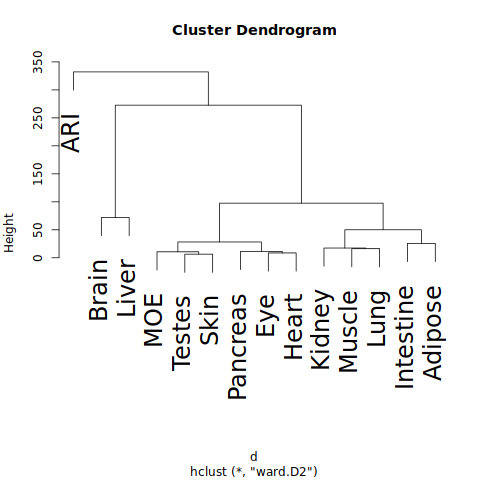

In [15]:
%%R
misclass_only.df <- rxn_tissue_mean_misclass.df[1:15]

numeric_data <- misclass_only.df %>% 
                select_if(~is.numeric(.))

# generate dendrogram
df <- scale(t(numeric_data))
d <- parallelDist::parallelDist(df, method = "euclidean")
saveRDS(d,file=paste(OUT_DIR,"misclass_dist_obj.Rds",sep=""))
hc1 <- hclust(d, method = "ward.D2" )
saveRDS(hc1,file=paste(OUT_DIR,"misclass_hc_obj.Rds",sep=""))
hc1 <- readRDS(paste(OUT_DIR,"misclass_hc_obj.Rds",sep=""))
dend1 <- as.dendrogram(hc1)
plot(hc1, cex = 2)

In [16]:
%%R
# generate figures using summary data frame
for(tis_idx in seq(1:15)){
  tis_name <- colnames(rxn_tissue_mean_misclass.df) %>% .[tis_idx]
  print(tis_name)
  if(!is.numeric(rxn_tissue_mean_misclass.df[[tis_name]])) next
    
  sorted.df <- rxn_tissue_mean_misclass.df %>% dplyr::arrange(ECOUNT)

  plot.obj <- ggplot2::ggplot(sorted.df) + 
    ggiraph::geom_point_interactive(aes(x=ARI,
                                      y=1 - !!as.name(tis_name),
                                      colour=ECOUNT,
                                      tooltip=RXN_ID,
                                      data_id=RXN_ID)) +
    theme_bw() + 
    ggtitle(paste("ARI vs ",tis_name," 1 - misclassification rate",sep=""))

  #girafe(ggobj = plot.obj)
  print(paste("ARI_v_",tis_name))
  ggsave(paste(OUT_DIR2,"ARI_v_",tis_name,"_misclassification.png"),device = png())  
  dev.off()
}

[1] "Brain"
[1] "ARI_v_ Brain"
Saving 6.67 x 6.67 in image
[1] "Liver"
[1] "ARI_v_ Liver"
Saving 6.67 x 6.67 in image
[1] "Intestine"
[1] "ARI_v_ Intestine"
Saving 6.67 x 6.67 in image
[1] "Eye"
[1] "ARI_v_ Eye"
Saving 6.67 x 6.67 in image
[1] "Heart"
[1] "ARI_v_ Heart"
Saving 6.67 x 6.67 in image
[1] "MOE"
[1] "ARI_v_ MOE"
Saving 6.67 x 6.67 in image
[1] "Muscle"
[1] "ARI_v_ Muscle"
Saving 6.67 x 6.67 in image
[1] "Lung"
[1] "ARI_v_ Lung"
Saving 6.67 x 6.67 in image
[1] "Kidney"
[1] "ARI_v_ Kidney"
Saving 6.67 x 6.67 in image
[1] "Pancreas"
[1] "ARI_v_ Pancreas"
Saving 6.67 x 6.67 in image
[1] "Testes"
[1] "ARI_v_ Testes"
Saving 6.67 x 6.67 in image
[1] "Adipose"
[1] "ARI_v_ Adipose"
Saving 6.67 x 6.67 in image
[1] "Skin"
[1] "ARI_v_ Skin"
Saving 6.67 x 6.67 in image
[1] "RXN_ID"
[1] "ARI"
[1] "ARI_v_ ARI"
Saving 6.67 x 6.67 in image


In [17]:
%%R
liver_columns <- grep("Liver", colnames(rxn_tissue_mean_misclass.df), value = TRUE)

for(liver_col in liver_columns) {
    sorted_df <- rxn_tissue_mean_misclass.df %>%
        dplyr::arrange(desc(!!as.name(liver_col))) %>%
        dplyr::slice(1:10)
    
    pca_scores <- lapply(sorted_df$RXN_ID, function(rxn_id) {
        rxn_pca.nls[[rxn_id]]
    })
    
    pca_scores_df <- do.call(rbind, pca_scores)
    
    print(pca_scores_df)
    write.csv(pca_scores_df, file=paste(OUT_DIR2, "Desc_PCA_scores_for_", liver_col, ".csv", sep=""))
}


              V1         V2          V3          V4         V5          V6
 [1,]  0.1660277  0.7851432 -3.26078579  0.01760079 0.27810889 -0.03874694
 [2,]  0.2337396  0.5250213  1.67227242 -0.72442300 0.51542283  0.07194290
 [3,] -2.2693489  0.8441770 -0.01236212  0.13516148 0.23665806  0.10822594
 [4,] -2.2693489  0.8441770 -0.01236212  0.13516148 0.23665806  0.10822594
 [5,] -0.2400923 -0.6928819  1.27845336  0.18773801 0.06767246  0.01753494
 [6,] -0.4825090 -0.0636373 -3.25862806  0.15266259 0.44797953  0.00333395
 [7,]  0.6271400 -0.5117355 -2.51665568  0.78471300 0.08832477 -0.49036853
 [8,]  0.6271400 -0.5117355 -2.51665568  0.78471300 0.08832477 -0.49036853
 [9,]  0.6271400 -0.5117355 -2.51665568  0.78471300 0.08832477 -0.49036853
[10,]  0.6271400 -0.5117355 -2.51665568  0.78471300 0.08832477 -0.49036853
              V7          V8          V9        V10        V11        V12
 [1,] -0.5488582  0.02079098 -0.01513345 -0.1546792 -0.1918310  0.1737892
 [2,] -0.3311988 -0.1676641

              V61        V62         V63         V64        V65        V66
 [1,]  0.50302403  0.4553479 -0.01781877  0.12505474  0.3565677  0.1899470
 [2,]  0.73286702  0.2105864  0.56510143 -0.18423003  0.1364602 -0.8115243
 [3,]  0.35411925  0.3761814 -0.08163733 -0.97258416  0.2886453 -1.0096624
 [4,]  0.35411925  0.3761814 -0.08163733 -0.97258416  0.2886453 -1.0096624
 [5,] -0.11737324  0.2606610  0.05883739  0.15461224 -0.2137580  0.2687196
 [6,]  0.26113628 -0.3548590  0.57397015 -0.06378696  0.2644636  0.2462936
 [7,]  0.03854354 -0.9225231  0.65187101  0.15338320 -0.3821580  0.5810829
 [8,]  0.03854354 -0.9225231  0.65187101  0.15338320 -0.3821580  0.5810829
 [9,]  0.03854354 -0.9225231  0.65187101  0.15338320 -0.3821580  0.5810829
[10,]  0.03854354 -0.9225231  0.65187101  0.15338320 -0.3821580  0.5810829
              V67          V68         V69          V70        V71         V72
 [1,] -0.38433591 -0.162988589  0.92103072  0.005324768 -0.6985905 -0.02236964
 [2,] -0.12491721

 [9,] -0.04968629  0.14959852  0.619505958 -0.30802831 -0.13331094  0.36075333
[10,] -0.04968629  0.14959852  0.619505958 -0.30802831 -0.13331094  0.36075333
            V121        V122        V123        V124       V125       V126
 [1,]  0.1499946 -0.39362224 -0.04568950 -0.05196303  0.9812306 -1.7522551
 [2,] -0.2731193 -0.16107148 -0.73727988 -0.52750782  0.8371641 -1.6366048
 [3,]  1.3225650 -0.40977082  0.15091142 -0.06921859  0.3024305 -0.6841706
 [4,]  1.3225650 -0.40977082  0.15091142 -0.06921859  0.3024305 -0.6841706
 [5,] -0.2146202 -0.04636287 -0.08030531  0.47633524  0.2696872 -0.1876981
 [6,]  0.5026409  0.23733886  0.43825343  0.13026851  0.7326649  0.1511476
 [7,]  0.1570770 -0.11657735 -1.04915159  0.72951825 -2.3705024  2.1330233
 [8,]  0.1570770 -0.11657735 -1.04915159  0.72951825 -2.3705024  2.1330233
 [9,]  0.1570770 -0.11657735 -1.04915159  0.72951825 -2.3705024  2.1330233
[10,]  0.1570770 -0.11657735 -1.04915159  0.72951825 -2.3705024  2.1330233
            V127 

 [8,]  0.1064860 -0.9984111 -0.2093528  0.420979531 -0.28445756  1.32955023
 [9,]  0.1064860 -0.9984111 -0.2093528  0.420979531 -0.28445756  1.32955023
[10,]  0.1064860 -0.9984111 -0.2093528  0.420979531 -0.28445756  1.32955023
            V181       V182       V183        V184        V185       V186
 [1,] -0.3054503 -0.6097115  0.1823552 -0.03487546 -0.09505357 -0.6477806
 [2,] -1.0586047 -1.2954603 -0.3371415 -0.12245684 -0.30188431 -1.3250956
 [3,]  0.8681358  0.6492630 -1.0845287 -0.13967079  0.33108448  0.6218777
 [4,]  0.8681358  0.6492630 -1.0845287 -0.13967079  0.33108448  0.6218777
 [5,] -1.2321328 -1.5137791  0.2106341 -0.17611069 -0.13353009 -1.5490186
 [6,]  2.8709361 -1.3676677  0.2461958  0.22188742  0.14128790 -1.3959069
 [7,] -0.4941188 -0.7187360  0.2416933 -0.15261982 -0.16210243 -0.7468401
 [8,] -0.4941188 -0.7187360  0.2416933 -0.15261982 -0.16210243 -0.7468401
 [9,] -0.4941188 -0.7187360  0.2416933 -0.15261982 -0.16210243 -0.7468401
[10,] -0.4941188 -0.7187360  0.2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 -1.16209597 -0.32443237  0.5083310 -0.24658970 -0.08409947
[10,]  0.69006444 -1.16209597 -0.32443237  0.5083310 -0.24658970 -0.08409947
             V523        V524       V525       V526         V527       V528
 [1,] -0.32033472  0.01618859  0.2134650 -0.4318903 -0.328358617 -0.7426973
 [2,] -0.64665859 -0.35426732  0.4684420  1.1175873 -1.172379845  5.2107618
 [3,]  0.02326312  0.71624523  0.1070532 -1.6662768  0.695250256  0.5535985
 [4,]  0.02326312  0.71624523  0.1070532 -1.6662768  0.695250256  0.5535985
 [5,] -0.49488328 -0.11936475 -0.1431797 -5.2261033  0.329339349  6.5068110
 [6,]  0.32475709  0.56230392  0.3207513 -0.7930476 -0.008861106 -1.4663147
 [7,] -0.24739551 -0.20924641 -0.5441439  2.8101395  0.294407061 -0.8169113
 [8,] -0.24739551 -0.20924641 -0.5441439  2.8101395  0.294407061 -0.8169113
 [9,] -0.24739551 -0.20924641 -0.5441439  2.8101395  0.294407061 -0.8169113
[10,] -0.24739551 -0.20924641 -0.5441439  2.8101395  0.294407061 -0.8169113
             V529        V5

 [6,]  0.15588004  0.4155876  0.2004605 -0.08778343  0.4095606  0.04429086
 [7,] -1.18207922 -0.3013082 -0.8758200  0.62755434  0.6553665 -0.85417914
 [8,] -1.18207922 -0.3013082 -0.8758200  0.62755434  0.6553665 -0.85417914
 [9,] -1.18207922 -0.3013082 -0.8758200  0.62755434  0.6553665 -0.85417914
[10,] -1.18207922 -0.3013082 -0.8758200  0.62755434  0.6553665 -0.85417914
             V583       V584       V585        V586       V587       V588
 [1,]  0.10134828 -0.7426973  0.1847140 -0.99111879 -0.1524034  0.1071155
 [2,] -0.13915569 -1.3989846  0.6716212  0.54871032 -0.5527834  0.4916132
 [3,]  0.49780027  0.5535985  0.1484789  0.34094244 -0.1960298 -0.3696733
 [4,]  0.49780027  0.5535985  0.1484789  0.34094244 -0.1960298 -0.3696733
 [5,]  0.04756538 -1.6368805 -0.4181345 -0.03777704 -0.4480378 -0.2118209
 [6,]  0.30872668  2.5561890  0.2650583 -1.01516857  0.4079352  0.1643394
 [7,]  0.12614274 -0.8169113 -0.3713398  0.19899428 -0.5668698  0.1057709
 [8,]  0.12614274 -0.8169113 -0.3

 [3,]  1.5237980  0.1629278 -0.3200386 -1.791343  0.2092006  2.15392207
 [4,]  1.5237980  0.1629278 -0.3200386 -1.791343  0.2092006  2.15392207
 [5,] -0.2946176  0.2274744  0.3742741 -4.654359  1.8605293  0.08697418
 [6,] -0.2703014  0.8101214  0.1119836 -3.884364  1.0668485 -0.05285898
 [7,]  0.5856932 -0.2565157  1.0296191  2.035563  0.9041809 -0.14715204
 [8,]  0.5856932 -0.2565157  1.0296191  2.035563  0.9041809 -0.14715204
 [9,]  0.5856932 -0.2565157  1.0296191  2.035563  0.9041809 -0.14715204
[10,]  0.5856932 -0.2565157  1.0296191  2.035563  0.9041809 -0.14715204
             V643       V644       V645       V646       V647       V648
 [1,]  0.06171739  0.6016666 -0.1480770 -0.1896470 -4.6252908 -1.3732346
 [2,]  0.05884861 -1.2884905 -0.3373249 -0.4047574  1.1962047  4.9869505
 [3,] -1.12205940 -1.1433699 -0.1225542 -0.3861695 -0.5100898  0.1000162
 [4,] -1.12205940 -1.1433699 -0.1225542 -0.3861695 -0.5100898  0.1000162
 [5,] -0.06764110  0.4313540 -0.4206885  0.1362171 -0.14752

 [1,]  0.2498869  0.22713877 -0.44196451 -0.1473235 -0.1050155 -2.236709287
 [2,]  0.6658576  0.09204412 -0.13100392 -1.2930417  0.3141866  0.007643677
 [3,] -0.1170963 -0.33091658 -0.32125691 -0.1451585  1.8276796 -0.504891135
 [4,] -0.1170963 -0.33091658 -0.32125691 -0.1451585  1.8276796 -0.504891135
 [5,] -0.3508339 -0.18136788  0.08463844  0.0440802 -0.3351822 -0.113034298
 [6,]  0.1538281  0.29628750  0.52671253  0.1500043  0.2783070  0.445403767
 [7,] -0.7461132 -0.47673936  0.16338269  0.7115142 -0.2526603  1.248328994
 [8,] -0.7461132 -0.47673936  0.16338269  0.7115142 -0.2526603  1.248328994
 [9,] -0.7461132 -0.47673936  0.16338269  0.7115142 -0.2526603  1.248328994
[10,] -0.7461132 -0.47673936  0.16338269  0.7115142 -0.2526603  1.248328994
            V703        V704       V705        V706       V707         V708
 [1,]  0.1750365  0.52803643 -0.3899355  0.17273272  0.3405017  0.008919844
 [2,] -0.1930258 -0.25285148  0.1801477 -0.08910339  0.0904930 -0.351016846
 [3,]  0.251

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

